# CPN009 - Export the enriched petri net to a CPN model

In [323]:
import pm4py

### Step 1: Import an event log (XES format)

In [324]:
from pm4py.objects.log.importer.xes import importer as xes_importer

FILE_NAME = "running-example"
INPUT_FILE_PATH = "input/" + FILE_NAME + ".xes"

log = xes_importer.apply(INPUT_FILE_PATH)

### Step 2: Discover a process model (using Inductive miner)

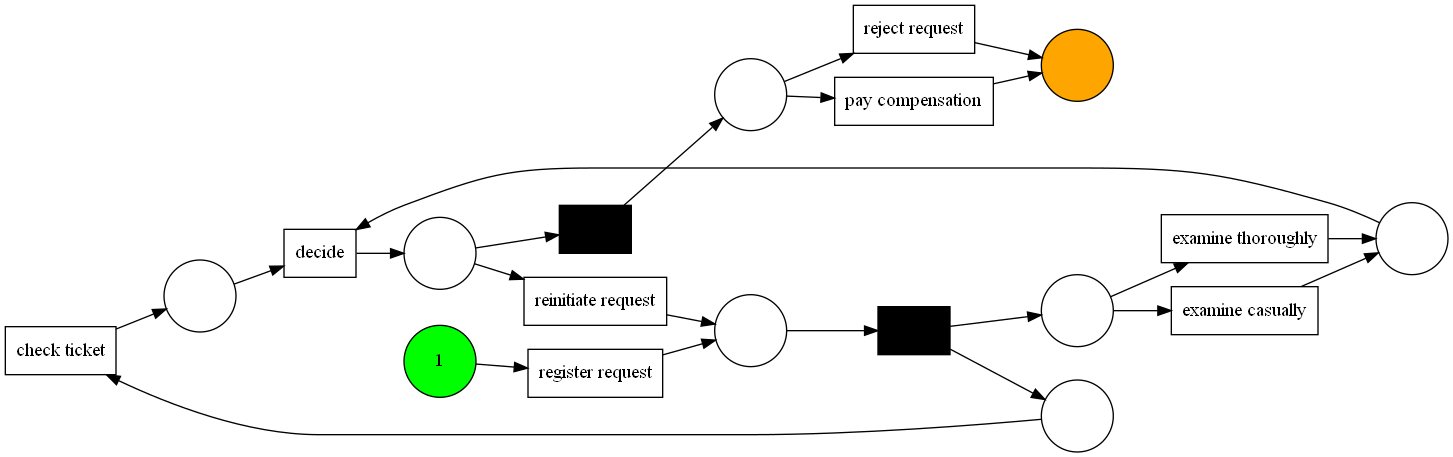

In [325]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petrinet import visualizer

net, initial_marking, final_marking = inductive_miner.apply(log)
gviz = visualizer.apply(net, initial_marking, final_marking)
visualizer.view(gviz)

### Step 3: Enrich performance information (used existing function in pm4py)

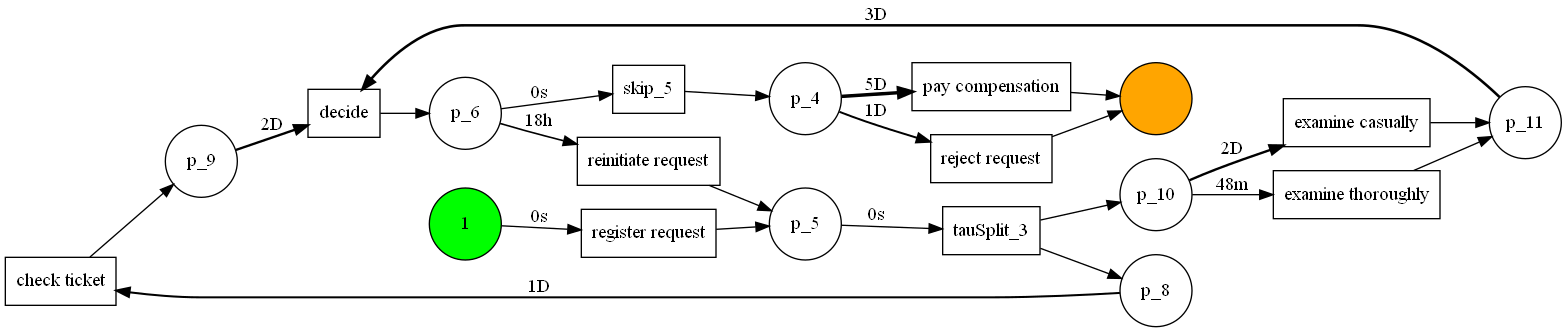

In [326]:
from pm4py.visualization.petrinet import visualizer as pn_visualizer

parameters = { 
    pn_visualizer.Variants.WO_DECORATION.value.Parameters.DEBUG: True, 
    pn_visualizer.Variants.PERFORMANCE.value.Parameters.FORMAT: "png" 
}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters, 
                           variant=pn_visualizer.Variants.PERFORMANCE, log=log)

OUTPUT_FILE_PATH = "output/" + FILE_NAME + "_inductive_perf.png"
pn_visualizer.save(gviz, OUTPUT_FILE_PATH)
pn_visualizer.view(gviz)

### Petri net characteristics

In [327]:
# The ellipses and circles are called places. They describe the states of the system.
print("Number of places: ", len(net.places))
print("Places are: ", net.places)
print("----------------------------------")

# The arrows are called arcs. 
# The arcexpressions describe how the state of the CP-net changes when the transitions occur.
print("Number of arcs: ", len(net.arcs))
print("Arcs are: ", net.arcs)
print("----------------------------------")

# The rectangles are called transitions. They describe the actions.
print("Number of transitions: ", len(net._PetriNet__transitions))
print("Transitions are: ", net._PetriNet__transitions)

Number of places:  9
Places are:  {p_6, p_9, source, p_4, p_5, p_10, p_8, p_11, sink}
----------------------------------
Number of arcs:  22
Arcs are:  {(p)source->(t)register request, (p)p_6->(t)reinitiate request, (p)p_4->(t)reject request, (p)p_4->(t)pay compensation, (p)p_8->(t)check ticket, (p)p_10->(t)examine thoroughly, (t)pay compensation->(p)sink, (t)examine casually->(p)p_11, (p)p_10->(t)examine casually, (t)skip_5->(p)p_4, (p)p_5->(t)tauSplit_3, (p)p_11->(t)decide, (t)reinitiate request->(p)p_5, (t)tauSplit_3->(p)p_10, (t)check ticket->(p)p_9, (p)p_9->(t)decide, (t)reject request->(p)sink, (t)tauSplit_3->(p)p_8, (t)register request->(p)p_5, (p)p_6->(t)skip_5, (t)decide->(p)p_6, (t)examine thoroughly->(p)p_11}
----------------------------------
Number of transitions:  10
Transitions are:  {examine casually, decide, register request, skip_5, reject request, reinitiate request, check ticket, pay compensation, tauSplit_3, examine thoroughly}


### Step 4: Export the enriched petri net to a CPN model

In [328]:
from xml.dom.minidom import DOMImplementation
import os
import json
import re
import uuid

# dictionary keys
DICT_KEY_OBJECTS_CONSTANT = "objects"
DICT_KEY_EDGES_CONSTANT = "edges"
LAYOUT_INFORMATION_PETRI = "layout_information_petri"
PERFORMANCE_INFORMATION_PETRI = "performance_information_petri"

# declaration constants
DECLARATION_COLOR_REQUEST = "REQUEST"
DECLARATION_COLOR_REQUEST_DATATYPE = "int"
DECLARATION_COLOR_REQUEST_VARIABLE = "r"
DECLARATION_COLOR_REQUEST_ITER_INDEX_START = 1
DECLARATION_COLOR_REQUEST_ITER_INDEX_END = 5
DECLARATION_COLOR_REQUEST_ITER_INSTANCE = "rq"
DECLARATION_COLOR_REQUEST_INSTANCES = DECLARATION_COLOR_REQUEST + ".all()"

# orientation constants
PLACE_TO_TRANS_ORIENTATION = "PtoT"
TRANS_TO_PLACE_ORIENTATION = "TtoP"

In [329]:
# retrive time information from performance labels and convert them to seconds
# egs of performance labels: 0s (seconds), 20m (minutes), 18h (hours), 5D (Days)
def convert_perf_label_to_seconds(perf_label):
    if(perf_label == ""):
        return None
    
    perf_regex = re.compile("([0-9]+)([a-zA-Z]+)")
    perf_matches = perf_regex.match(perf_label)
    
    perf_number = perf_matches.group(1)
    perf_str = perf_matches.group(2)
    
    if (perf_str == "s"):
        return int(perf_number)
    elif (perf_str == "m"):
        return int(perf_number) * 60 # seconds = minutes * 60
    elif (perf_str == "h"):
        return int(perf_number) * 3600 # seconds = hours * 3600
    elif (perf_str == "D"):
        return int(perf_number) * 86400 # seconds = days * 86400
    else:
        return None

In [330]:
# extracts the layout information - x_position, y_position, height and width of graph elements
# and stores them in the place/transition/arc .properties[LAYOUT_INFORMATION_PETRI]
# This is needs to be inserted into the cpn file for cpn tools to accurately place the elements in the UI

def extract_layout_info_to_petri_net_properties(graph, petri_net):
    
    # height and width obtained from graph seems to be in ratios??
    # use the constants to multiply the ratios
    HEIGHT_EXTENSION_CONSTANT = 30
    WIDTH_EXTENSION_CONSTANT = 30

    # decode the Digraph to JSON format
    json_string = gviz.pipe('json').decode()
    # parse the resulting json_string
    json_dict = json.loads(json_string)

    # rename source and sink labels in json dictionary
    # source label would be "1" in the dict and sink would be ""
    source_obj = next(item for item in json_dict[DICT_KEY_OBJECTS_CONSTANT] if item["label"] == "1")
    source_obj["label"] = "source"
    sink_obj = next(item for item in json_dict[DICT_KEY_OBJECTS_CONSTANT] if item["label"] == "")
    sink_obj["label"] = "sink"
    
    # store place's layout information in the properties dictionary
    for place in petri_net.places:
        # retreive the place info object from the digraph json dictionary
        obj = next(item for item in json_dict[DICT_KEY_OBJECTS_CONSTANT] if item["label"] == str(place))
        pos = obj["pos"].split(',') # the position x and y is a comma seperated string in the dict
        place.properties[constants.LAYOUT_INFORMATION_PETRI] = [
            [ float(pos[0]), float(pos[1]) ],
            [ float(obj["height"]) * HEIGHT_EXTENSION_CONSTANT, float(obj["width"]) * WIDTH_EXTENSION_CONSTANT ]
        ]
    
    # store transition's layout information in the properties dictionary
    for trans in petri_net.transitions:
        # retreive the transition info object from the digraph json dictionary
        obj = next(item for item in json_dict[DICT_KEY_OBJECTS_CONSTANT] if item["label"] == str(trans))
        pos = obj["pos"].split(',') # the position x and y is a comma seperated string in the dict
        trans.properties[constants.LAYOUT_INFORMATION_PETRI] = [
            [ float(pos[0]), float(pos[1]) ],
            [ float(obj["height"]) * HEIGHT_EXTENSION_CONSTANT, float(obj["width"]) * WIDTH_EXTENSION_CONSTANT ]
        ]
        
    # store arc's layout information for annotations in the properties dictionary
    for item in json_dict[DICT_KEY_EDGES_CONSTANT]:
        source = json_dict["objects"][item["tail"]]
        target = json_dict["objects"][item["head"]]
        # retreive the object with matching source and target label from the petri net arcs
        arc = next(arc for arc in net.arcs if str(arc.source) == str(source["label"]) and str(arc.target) == str(target["label"]))
        pos = item["pos"].split(' ')[3].split(',')
        arc.properties[LAYOUT_INFORMATION_PETRI] = [
            [ float(pos[0]), float(pos[1])]
        ]
        # TODO: Refactor this code
        # store waiting time in the properties dictionary if target is a transition (this is used to induce delay later in cpn)
        # else store the execution time in arc properties (this is used to set exec time later in cpn)
        is_target_trans = isinstance(arc.target, pm4py.objects.petri.petrinet.PetriNet.Transition)
        if (is_target_trans):
            arc.target.properties[PERFORMANCE_INFORMATION_PETRI] = convert_perf_label_to_seconds(item["label"])
        else:
            arc.properties[PERFORMANCE_INFORMATION_PETRI] = convert_perf_label_to_seconds(item["label"])


In [331]:
# globbox element in the cpn file contains color set declarations
def create_globbox_element_for_document(document):
    globbox_tag = document.createElement("globbox")
    
    # setup color set declarations
    
    color_tag = document.createElement("color")
    color_tag.setAttribute("id", str(uuid.uuid1().hex))
    
    colorid_tag = document.createElement("id")
    colorid_tag.appendChild(document.createTextNode(str(DECLARATION_COLOR_REQUEST)))
    color_tag.appendChild(colorid_tag)
    
    colortimed_tag = document.createElement("timed")
    color_tag.appendChild(colortimed_tag)
    
    colorindex_tag = document.createElement("index")
    colorml_tag = document.createElement("ml")
    colorml_tag.appendChild(document.createTextNode(str(DECLARATION_COLOR_REQUEST_ITER_INDEX_START)))
    colorindex_tag.appendChild(colorml_tag)
    colorml_tag = document.createElement("ml")
    colorml_tag.appendChild(document.createTextNode(str(DECLARATION_COLOR_REQUEST_ITER_INDEX_END)))
    colorindex_tag.appendChild(colorml_tag)
    colorindexid_tag = document.createElement("id")
    colorindexid_tag.appendChild(document.createTextNode(str(DECLARATION_COLOR_REQUEST_ITER_INSTANCE)))
    colorindex_tag.appendChild(colorindexid_tag)
    
    color_tag.appendChild(colorindex_tag)
    
    globbox_tag.appendChild(color_tag)
    
    # setup color set variables declarations
    
    var_tag = document.createElement("var")
    var_tag.setAttribute("id", str(uuid.uuid1().hex))
    
    vartype_tag = document.createElement("type")
    vartypeid_tag = document.createElement("id")
    vartypeid_tag.appendChild(document.createTextNode(str(DECLARATION_COLOR_REQUEST)))
    vartype_tag.appendChild(vartypeid_tag)
    var_tag.appendChild(vartype_tag)
    
    varid_tag = document.createElement("id")
    varid_tag.appendChild(document.createTextNode(str(DECLARATION_COLOR_REQUEST_VARIABLE)))
    var_tag.appendChild(varid_tag)
    
    globbox_tag.appendChild(var_tag)

    return globbox_tag
    
    
# page element in the cpn file contains all the places, transitions and arcs
def create_page_element_for_document(document, petri_net, initial_marking, final_marking, parameters=None):
    
    # <page>
    page_tag = document.createElement("page")
    page_tag.setAttribute("id", str(uuid.uuid1().hex))
    
    # <pageattr name="Page"/>
    pageattr_tag = document.createElement("pageattr")
    pageattr_tag.setAttribute("name", "Page")
    page_tag.appendChild(pageattr_tag)

    # <place>, setup for place ellipses
    for place in petri_net.places:
        place_tag = document.createElement("place")
        place_tag.setAttribute("id", str(place.name))
        
        posattr_tag = document.createElement("posattr")
        posattr_tag.setAttribute("x", str(place.properties[LAYOUT_INFORMATION_PETRI][0][0]))
        posattr_tag.setAttribute("y", str(place.properties[LAYOUT_INFORMATION_PETRI][0][1]))
        place_tag.appendChild(posattr_tag)
        
        # set fill color for places: Teal(Source), Red(Sink) and White(Others)
        fillattr_tag = document.createElement("fillattr")
        if place in initial_marking.keys():
            fillattr_tag.setAttribute("colour", "Teal")
        elif place in final_marking.keys():
            fillattr_tag.setAttribute("colour", "Red")
        else:
            fillattr_tag.setAttribute("colour", "White")
        fillattr_tag.setAttribute("pattern", "Solid")
        fillattr_tag.setAttribute("filled", "false")
        place_tag.appendChild(fillattr_tag)
        
        lineattr_tag = document.createElement("lineattr")
        lineattr_tag.setAttribute("colour", "Black")
        lineattr_tag.setAttribute("thick", "2")
        lineattr_tag.setAttribute("type", "Solid")
        place_tag.appendChild(lineattr_tag)
        
        textattr_tag = document.createElement("textattr")
        textattr_tag.setAttribute("colour", "Black")
        textattr_tag.setAttribute("bold", "false")
        place_tag.appendChild(textattr_tag)
        
        text_tag = document.createElement("text")
        text_tag.appendChild(document.createTextNode(str(place)))
        place_tag.appendChild(text_tag)

        ellipse_tag = document.createElement("ellipse")
        ellipse_tag.setAttribute("h", str(place.properties[LAYOUT_INFORMATION_PETRI][1][0]))
        ellipse_tag.setAttribute("w", str(place.properties[LAYOUT_INFORMATION_PETRI][1][1]))
        place_tag.appendChild(ellipse_tag)
        
        # TODO: Handle tokens
        token_tag = document.createElement("token")
        token_tag.setAttribute("x", "0.000000")
        token_tag.setAttribute("y", "0.000000")
        place_tag.appendChild(token_tag)
        
        # TODO: Handle markings
        marking_tag = document.createElement("marking")
        marking_tag.setAttribute("x", "0.000000")
        marking_tag.setAttribute("y", "0.000000")
        place_tag.appendChild(marking_tag)
        
        type_tag = document.createElement("type")
        type_tag.setAttribute("id", str(uuid.uuid1().hex))
        
        # color set type for places, setup type tag at bottom-right of the place
        posattr_tag = document.createElement("posattr")
        # attribute position_x = place_position_x + place_width
        posattr_tag.setAttribute("x", str( 
            place.properties[LAYOUT_INFORMATION_PETRI][0][0] + 
            place.properties[LAYOUT_INFORMATION_PETRI][1][1]
        ))
        # attribute position_y = place_y_position - place_height/2
        posattr_tag.setAttribute("y", str(
            place.properties[LAYOUT_INFORMATION_PETRI][0][1] - 
            ( place.properties[LAYOUT_INFORMATION_PETRI][1][0] / 2)
        ))
        type_tag.appendChild(posattr_tag)
        
        fillattr_tag = document.createElement("fillattr")
        fillattr_tag.setAttribute("colour", "White")
        fillattr_tag.setAttribute("pattern", "Solid")
        fillattr_tag.setAttribute("filled", "false")
        type_tag.appendChild(fillattr_tag)
        
        lineattr_tag = document.createElement("lineattr")
        lineattr_tag.setAttribute("colour", "Black")
        lineattr_tag.setAttribute("thick", "0")
        lineattr_tag.setAttribute("type", "Solid")
        type_tag.appendChild(lineattr_tag)
        
        textattr_tag = document.createElement("textattr")
        textattr_tag.setAttribute("colour", "Black")
        textattr_tag.setAttribute("bold", "false")
        type_tag.appendChild(textattr_tag)
        
        text_tag = document.createElement("text")
        text_tag.appendChild(document.createTextNode(str(DECLARATION_COLOR_REQUEST)))
        type_tag.appendChild(text_tag)
        
        place_tag.appendChild(type_tag)
        
        # for places that are initial_marking, setup initial_marking tag at top-right of the place
        if place in initial_marking.keys():
            initmark_tag = document.createElement("initmark")
            initmark_tag.setAttribute("id", str(uuid.uuid1().hex))

            posattr_tag = document.createElement("posattr")
             # initial_marking position_x = place_x_position + place_width
            posattr_tag.setAttribute("x", str( 
                place.properties[LAYOUT_INFORMATION_PETRI][0][0] + 
                place.properties[LAYOUT_INFORMATION_PETRI][1][1]
            ))
            # initial_marking position_y = place_y_position + place_height/2
            posattr_tag.setAttribute("y", str(
                place.properties[LAYOUT_INFORMATION_PETRI][0][1] + 
                ( place.properties[LAYOUT_INFORMATION_PETRI][1][0] / 2 )
            ))
            initmark_tag.appendChild(posattr_tag)

            fillattr_tag = document.createElement("fillattr")
            fillattr_tag.setAttribute("colour", "White")
            fillattr_tag.setAttribute("pattern", "Solid")
            fillattr_tag.setAttribute("filled", "false")
            initmark_tag.appendChild(fillattr_tag)

            lineattr_tag = document.createElement("lineattr")
            lineattr_tag.setAttribute("colour", "Black")
            lineattr_tag.setAttribute("thick", "0")
            lineattr_tag.setAttribute("type", "Solid")
            initmark_tag.appendChild(lineattr_tag)

            textattr_tag = document.createElement("textattr")
            textattr_tag.setAttribute("colour", "Black")
            textattr_tag.setAttribute("bold", "false")
            initmark_tag.appendChild(textattr_tag)

            text_tag = document.createElement("text")
            text_tag.appendChild(document.createTextNode(str(DECLARATION_COLOR_REQUEST_INSTANCES)))
            initmark_tag.appendChild(text_tag)

            place_tag.appendChild(initmark_tag)
        
        page_tag.appendChild(place_tag)

      
    # <trans>, setup for transition rectangles
    for trans in petri_net.transitions:
        trans_tag = document.createElement("trans")
        # remove hypens from the guid (or else cpntool will crash)
        trans_tag.setAttribute("id", str(trans.name).replace('-', ''))
        
        posattr_tag = document.createElement("posattr")
        posattr_tag.setAttribute("x", str(trans.properties[LAYOUT_INFORMATION_PETRI][0][0]))
        posattr_tag.setAttribute("y", str(trans.properties[LAYOUT_INFORMATION_PETRI][0][1]))
        trans_tag.appendChild(posattr_tag)
        
        fillattr_tag = document.createElement("fillattr")
        fillattr_tag.setAttribute("colour", "White")
        fillattr_tag.setAttribute("pattern", "Solid")
        fillattr_tag.setAttribute("filled", "false")
        trans_tag.appendChild(fillattr_tag)
        
        lineattr_tag = document.createElement("lineattr")
        lineattr_tag.setAttribute("colour", "Black")
        lineattr_tag.setAttribute("thick", "2")
        lineattr_tag.setAttribute("type", "Solid")
        trans_tag.appendChild(lineattr_tag)
        
        textattr_tag = document.createElement("textattr")
        textattr_tag.setAttribute("colour", "Black")
        textattr_tag.setAttribute("bold", "false")
        trans_tag.appendChild(textattr_tag)
        
        text_tag = document.createElement("text")
        text_tag.appendChild(document.createTextNode(str(trans)))
        trans_tag.appendChild(text_tag)
        
        box_tag = document.createElement("box")
        box_tag.setAttribute("h", str(trans.properties[LAYOUT_INFORMATION_PETRI][1][0]))
        box_tag.setAttribute("w", str(trans.properties[LAYOUT_INFORMATION_PETRI][1][1]))
        trans_tag.appendChild(box_tag)
        
        time_tag = document.createElement("time")
        time_tag.setAttribute("id", str(uuid.uuid1().hex))

        posattr_tag = document.createElement("posattr")
         # time position_x = place_x_position + place_width/1.5
        posattr_tag.setAttribute("x", str( 
            trans.properties[LAYOUT_INFORMATION_PETRI][0][0] + 
            ( trans.properties[LAYOUT_INFORMATION_PETRI][1][1] / 1.5 )
        ))
        # time position_y = place_y_position - place_height/1.5
        posattr_tag.setAttribute("y", str(
            trans.properties[LAYOUT_INFORMATION_PETRI][0][1] -
            ( trans.properties[LAYOUT_INFORMATION_PETRI][1][0] / 1.5 )
        ))
        time_tag.appendChild(posattr_tag)

        fillattr_tag = document.createElement("fillattr")
        fillattr_tag.setAttribute("colour", "White")
        fillattr_tag.setAttribute("pattern", "Solid")
        fillattr_tag.setAttribute("filled", "false")
        time_tag.appendChild(fillattr_tag)

        lineattr_tag = document.createElement("lineattr")
        lineattr_tag.setAttribute("colour", "Teal")
        lineattr_tag.setAttribute("thick", "0")
        lineattr_tag.setAttribute("type", "Solid")
        time_tag.appendChild(lineattr_tag)

        textattr_tag = document.createElement("textattr")
        textattr_tag.setAttribute("colour", "Teal")
        textattr_tag.setAttribute("bold", "false")
        time_tag.appendChild(textattr_tag)

        text_tag = document.createElement("text")
        text_tag.appendChild(document.createTextNode("@+" + str(trans.properties[PERFORMANCE_INFORMATION_PETRI])))
        time_tag.appendChild(text_tag)
        
        trans_tag.appendChild(time_tag)
        
        page_tag.appendChild(trans_tag)
    
    
    # <arcs>, setup for arcs
    for arc in petri_net.arcs:
        # identify the place and transition ends of the arc
        is_target_trans = isinstance(arc.target, pm4py.objects.petri.petrinet.PetriNet.Transition)
        is_target_place = isinstance(arc.target, pm4py.objects.petri.petrinet.PetriNet.Place)
        
        # identify orientation of the arc, Place->Trans or Trans->Place
        orientation = PLACE_TO_TRANS_ORIENTATION if is_target_trans else TRANS_TO_PLACE_ORIENTATION
        
        # remove hypens from the transend_idref (since we removed the same from transition id above)
        # these id's are references to <place> and <transition> tags generated above
        transend_idref = str(arc.target.name).replace('-', '') if is_target_trans else str(arc.source.name).replace('-', '')
        placeend_idref = str(arc.target.name) if is_target_place else str(arc.source.name)
        
        arc_tag = document.createElement("arc")
        arc_tag.setAttribute("id", str(uuid.uuid1().hex))
        arc_tag.setAttribute("orientation", orientation)
        
        posattr_tag = document.createElement("posattr")
        posattr_tag.setAttribute("x", "0.000000")
        posattr_tag.setAttribute("y", "0.000000")
        arc_tag.appendChild(posattr_tag)
        
        fillattr_tag = document.createElement("fillattr")
        fillattr_tag.setAttribute("colour", "White")
        fillattr_tag.setAttribute("pattern", "Solid")
        fillattr_tag.setAttribute("filled", "false")
        arc_tag.appendChild(fillattr_tag)
        
        lineattr_tag = document.createElement("lineattr")
        lineattr_tag.setAttribute("colour", "Black")
        lineattr_tag.setAttribute("thick", "2")
        lineattr_tag.setAttribute("type", "Solid")
        arc_tag.appendChild(lineattr_tag)
        
        textattr_tag = document.createElement("textattr")
        textattr_tag.setAttribute("colour", "Black")
        textattr_tag.setAttribute("bold", "false")
        arc_tag.appendChild(textattr_tag)
        
        arrowattr_tag = document.createElement("arrowattr")
        arrowattr_tag.setAttribute("headsize", "1.000000")
        arrowattr_tag.setAttribute("currentcyckle", "2")
        arc_tag.appendChild(arrowattr_tag)
        
        transend_tag = document.createElement("transend")
        transend_tag.setAttribute("idref", transend_idref)
        arc_tag.appendChild(transend_tag)
        
        placeend_tag = document.createElement("placeend")
        placeend_tag.setAttribute("idref", placeend_idref)
        arc_tag.appendChild(placeend_tag)
        
        # TODO: <bendpoint> - do we need this?
        
        annot_tag = document.createElement("annot")
        annot_tag.setAttribute("id", str(uuid.uuid1().hex))
        
        posattr_tag = document.createElement("posattr")
        posattr_tag.setAttribute("x", str(arc.properties[LAYOUT_INFORMATION_PETRI][0][0]))
        # move y position by 5 else the arc annotation will end up lying on the arc
        posattr_tag.setAttribute("y",str(arc.properties[LAYOUT_INFORMATION_PETRI][0][1] + 5))
        annot_tag.appendChild(posattr_tag)
        
        fillattr_tag = document.createElement("fillattr")
        fillattr_tag.setAttribute("colour", "White")
        fillattr_tag.setAttribute("pattern", "Solid")
        fillattr_tag.setAttribute("filled", "false")
        annot_tag.appendChild(fillattr_tag)
        
        lineattr_tag = document.createElement("lineattr")
        lineattr_tag.setAttribute("colour", "Black")
        lineattr_tag.setAttribute("thick", "0")
        lineattr_tag.setAttribute("type", "Solid")
        annot_tag.appendChild(lineattr_tag)
        
        textattr_tag = document.createElement("textattr")
        textattr_tag.setAttribute("colour", "Black")
        textattr_tag.setAttribute("bold", "false")
        annot_tag.appendChild(textattr_tag)
        
        text_tag = document.createElement("text")
        # TODO: "@+2" is a dummy. Needs to be removed later
        # For now there's no execution time information on the arc transition->place, 
        # Once it's implemented replace the dummy "@+2" by the execution time stored in arc.properties[PERFORMANCE_INFORMATION_PETRI]
        if(is_target_place):
            text_tag.appendChild(document.createTextNode(str(DECLARATION_COLOR_REQUEST_VARIABLE) + "@+2"))
        else:
            text_tag.appendChild(document.createTextNode(str(DECLARATION_COLOR_REQUEST_VARIABLE)))   
        annot_tag.appendChild(text_tag)
        
        arc_tag.appendChild(annot_tag)
        
        page_tag.appendChild(arc_tag)
        
    return page_tag


# Genarates a cpn dom object filled with information from the petri net
def create_cpn_model_from_petri_net(petri_net, initial_marking, final_marking, parameters=None):
    
    custom_dom_imp = DOMImplementation()
    
    # <!DOCTYPE workspaceElements PUBLIC "-//CPN//DTD CPNXML 1.0//EN" "http://www.daimi.au.dk/~cpntools/bin/DTD/2/cpn.dtd">
    doctype = custom_dom_imp.createDocumentType(
        qualifiedName="workspaceElements",
        publicId="-//CPN//DTD CPNXML 1.0//EN",
        systemId="http://www.daimi.au.dk/~cpntools/bin/DTD/2/cpn.dtd",
    )

    document = custom_dom_imp.createDocument(None, "workspaceElements", doctype)

    workspaceElements = document.getElementsByTagName("workspaceElements")[0]

    # <generator tool="CPN Tools" version="0.1.69.1" format="2"/>
    generator_tag = document.createElement("generator") 
    generator_tag.setAttribute("tool", "CPN Tools") 
    generator_tag.setAttribute("version", "0.1.69.1")
    generator_tag.setAttribute("format", "2")
    workspaceElements.appendChild(generator_tag) 

    # <cpnet>
    cpnet_tag = document.createElement("cpnet")
    workspaceElements.appendChild(cpnet_tag)

    # <globbox>
    globbox_tag = create_globbox_element_for_document(document)
    cpnet_tag.appendChild(globbox_tag)

    # <page>
    page_tag = create_page_element_for_document(document, petri_net, initial_marking, final_marking, parameters=None)
    cpnet_tag.appendChild(page_tag)
    
    return document    

In [332]:
# export xml as cpn file  
def save_cpn_model(model, filepath):
    # <?xml version="1.0" encoding="iso-8859-1"?>
    xml_str = model.toprettyxml(encoding="iso-8859-1")  
    with open(filepath, "wb") as file: 
        file.write(xml_str)

In [333]:
# extract layout information from graphviz to insert into petrinet place/transitions properties
extract_layout_info_to_petri_net_properties(gviz, net)

cpn_model = create_cpn_model_from_petri_net(net, initial_marking, final_marking)

OUTPUT_FILE_PATH = "output/" + FILE_NAME + ".cpn"
save_cpn_model(cpn_model, OUTPUT_FILE_PATH)